In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import os

from os.path import join as ospj
from os.path import expanduser
from munch import Munch as mch
import numpy as np
from tqdm import tqdm

import clip

from ds import prepare_coco_dataloaders, prepare_flickr_dataloaders, prepare_cub_dataloaders, prepare_flo_dataloaders, prepare_cub_dataloaders_extra
import torch.distributions as dist

import matplotlib.pyplot as plt

In [2]:
from transformers import CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch16") 


import torch
device = "cuda"
# # Path to the saved model checkpoint ---> this pth needs to be updated
# checkpoint_path = '../ProbVLM/ckpt/ProbVLM_CUB_Net_200epo_24.11_best.pth'

# # Load the checkpoint
# checkpoint = torch.load(checkpoint_path, map_location=device)




../ProbVLM/prob2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import torch.nn as nn
class BayesCap_MLP(nn.Module):
    '''
    Baseclass to create a simple MLP
    Inputs
        inp_dim: int, Input dimension
        out_dim: int, Output dimension
        hid_dim: int, hidden dimension
        num_layers: Number of hidden layers
        p_drop: dropout probability 
    '''
    def __init__(
        self, 
        inp_dim, 
        out_dim,
        hid_dim=512, 
        num_layers=1, 
        p_drop=0,
    ):
        super(BayesCap_MLP, self).__init__()
        mod = []
        for layer in range(num_layers):
            if layer==0:
                incoming = inp_dim
                outgoing = hid_dim
                mod.append(nn.Linear(incoming, outgoing))
                mod.append(nn.ReLU())
            elif layer==num_layers//2:
                incoming = hid_dim
                outgoing = hid_dim
                mod.append(nn.Linear(incoming, outgoing))
                mod.append(nn.ReLU())
                mod.append(nn.Dropout(p=p_drop))
            elif layer==num_layers-1:
                incoming = hid_dim
                outgoing = out_dim
                mod.append(nn.Linear(incoming, outgoing))
        self.mod = nn.Sequential(*mod)

        self.block_mu = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
        )

        self.block_alpha = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            # nn.Linear(out_dim, out_dim),
            # nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
        )

        self.block_beta = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            # nn.Linear(out_dim, out_dim),
            # nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x_intr = self.mod(x)
        print('dbg', x_intr.shape, x.shape)
        x_intr = x_intr + x
        x_mu = self.block_mu(x_intr)
        x_1alpha = self.block_alpha(x_intr)
        x_beta = self.block_beta(x_intr)
        return x_mu, x_1alpha, x_beta

class BayesCLIP(nn.Module):
    def __init__(
        self,
        model_path=None,
        device='cuda',
    ):
        super(BayesCLIP, self).__init__()
        self.clip_model = load_model_p(device, model_path)
        self.clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.img_BayesCap = BayesCap_MLP(inp_dim=1024, out_dim=1024, hid_dim=512, num_layers=3, p_drop=0.3).to(device)
        self.txt_BayesCap = BayesCap_MLP(inp_dim=1024, out_dim=1024, hid_dim=512, num_layers=3, p_drop=0.3).to(device)

    def forward(self, i_inputs, t_inputs):
        i_features, t_features = self.clip_model(i_inputs, t_inputs)

        img_mu, img_1alpha, img_beta = self.img_BayesCap(i_features)
        txt_mu, txt_1alpha, txt_beta = self.txt_BayesCap(t_features)

        return (img_mu, img_1alpha, img_beta), (txt_mu, txt_1alpha, txt_beta), (i_features, t_features)


class BayesCap_for_CLIP(nn.Module):
    def __init__(
        self,
        inp_dim=1024,
        out_dim=1024,
        hid_dim=512,
        num_layers=3,
        p_drop=0.1,
    ):
        super(BayesCap_for_CLIP, self).__init__()
        self.img_BayesCap = BayesCap_MLP(inp_dim=inp_dim, out_dim=out_dim, hid_dim=hid_dim, num_layers=num_layers, p_drop=p_drop)
        self.txt_BayesCap = BayesCap_MLP(inp_dim=inp_dim, out_dim=out_dim, hid_dim=hid_dim, num_layers=num_layers, p_drop=p_drop)

    def forward(self, i_features, t_features):
        
        # print('dbg', i_features.shape, t_features.shape)
        img_mu, img_1alpha, img_beta = self.img_BayesCap(i_features)
        txt_mu, txt_1alpha, txt_beta = self.txt_BayesCap(t_features)

        return (img_mu, img_1alpha, img_beta), (txt_mu, txt_1alpha, txt_beta)
    
    
def load_data_loader(dataset, data_dir, dataloader_config):
    prepare_loaders = {
        'coco': prepare_coco_dataloaders,
        'flickr': prepare_flickr_dataloaders,
        'CUB':prepare_cub_dataloaders,
        'waterbird_1.0_forest2water2':prepare_cub_dataloaders_extra,
        'FLO':prepare_flo_dataloaders
    }[dataset]
    if dataset == 'CUB' or dataset == 'waterbird_1.0_forest2water2':
        loaders = prepare_loaders(
            dataloader_config,
            dataset_root=data_dir,
            caption_root='../ProbVLM/Datasets/text_c10')
    elif dataset == 'FLO':
        loaders = prepare_loaders(
            dataloader_config,
            dataset_root=data_dir,
            caption_root=data_dir+'/text_c10',)
    else:
        loaders = prepare_loaders(
            dataloader_config,
            dataset_root=data_dir,
            vocab_path='ds/vocabs/coco_vocab.pkl')
    return loaders

def load_model_p(device, model_path=None):
    # load zero-shot CLIP model
    model, _ = clip.load(name='RN50',
                         device=device,
                         loss_type='contrastive')
    if model_path is None:
        # Convert the dtype of parameters from float16 to float32
        for name, param in model.named_parameters():
            param.data = param.data.type(torch.float32)
    else:
        ckpt = torch.load(model_path)
        model.load_state_dict(ckpt['state_dict'])
        for name, param in model.named_parameters():
            param.data = param.data.type(torch.float32)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    return model


def sample_ggd(x_mu, x_1alpha, x_beta, num_samples=100):
    
    """
    
    Fucntion needs to be modified so that we can draw a sample from the distri
    Sample from a GGD with parameters (mu, alpha, beta).
    
    Args:
        x_mu: Tensor, the location parameter (mean).
        x_1alpha: Tensor, the scale parameter.
        x_beta: Tensor, the shape parameter.
        num_samples: int, number of samples to draw.
        
    Returns:
        feature_vector: Tensor, derived feature vector from GGD samples.
        
        
    """
    # Add a small epsilon to x_1alpha to avoid zero values
    epsilon = 1e-6
    x_1alpha_adjusted = x_1alpha + epsilon

    # Create an approximate normal distribution
    ggd_dist = dist.Normal(x_mu, x_1alpha_adjusted)

    # Sample and compute feature vector (e.g., mean of samples)
    samples = ggd_dist.sample((num_samples,))

    return samples


### Feature Vectors Extraction with GGD

Iterate through each batch:

1. Compute the encoding of (img, txt) using CLIP: xfT, xfI
2. Obtain parameters using BayesCap_MLP: img_mu, img_alpha, img_beta, txt_mu, txt_alpha, txt_beta
3. Plug values into GGD to obtain feature vectors 

### Compute Attention

Given a batch of imgs (V), and texts (T):

1. Do similarity/attention scores (dot production) of image features V and text features T. att_s = (V * T')
2. Compute the attention weights: softmax (att_s) 

### Save attention maps as GALS saves the att

### 1. Loaders


In [4]:
import pickle
import os

def save_data_loaders(loaders, filename):
    with open(filename, 'wb') as f:
        pickle.dump(loaders, f)

def load_data_loaders(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

# Usage
dataset = 'waterbird_1.0_forest2water2'  # coco or flickr
data_dir = ospj('../ProbVLM/Datasets/', dataset)
dataloader_config = mch({
    'batch_size': 64,
    'random_erasing_prob': 0.,
    'traindata_shuffle': True
})

filename = '../ProbVLM/Datasets/CUB/data_loaders_waterbirds_12.12.pkl'
loaders = load_data_loaders(filename)

if loaders is None:
    loaders = load_data_loader(dataset, data_dir, dataloader_config)
    save_data_loaders(loaders, filename)


cub_train_loader, cub_valid_loader, cub_test_loader = loaders['train'], loaders['val'], loaders['test']

In [5]:
device='cuda'
CLIP_Net = load_model_p(device=device, model_path=None)


In [ ]:
# ProbVLM_Net = BayesCap_for_CLIP(inp_dim=1024,
#         out_dim=1024,
#         hid_dim=512,
#         num_layers=3,
#         p_drop=0.1,
#     )


# # In[15]:

# ProbVLM_Net = ProbVLM_Net.to(device)
# ProbVLM_Net.load_state_dict(checkpoint)
# ProbVLM_Net.eval()

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import torch


In [7]:
text_list = ["an image of a bird", "a photo of a bird"]

In [8]:
from grad_cam import GradCAM
import torchray
from torchray.attribution.grad_cam import grad_cam as tr_gradcam
import attention_utils_p as au

In [9]:

class AttentionVLModel(nn.Module):
    def __init__(self, base_model, gradcam_layer='layer4.2.relu'):
        super(AttentionVLModel, self).__init__()
        self.base_model = base_model.module
        self.gradcam = GradCAM(model=self.base_model, candidate_layers=[gradcam_layer])
    
    def forward(self, image_path, img_f, text_f, text_list, tok_t, tok_i, device):

        # Generate attention map
        attention_data = au.clip_gcam_prob(
            model=self.base_model,
            file_path=image_path,
            text_list=text_list,
            img_f = img_f,
            text_f = text_f,
            tokenized_text = tok_t,
            tokenized_img = tok_i,
            layer=self.gradcam.candidate_layers[0],
            device=device,
            plot_vis=False,
            save_vis_path = '../ProbVLM/src/attention/CUB'
        )

        # Extract relevant outputs
        attentions, probs, unnorm_attentions, text = attention_data['attentions'], attention_data['probs'], attention_data['unnormalized_attentions'], attention_data['text_list']
        return attentions, probs, unnorm_attentions, text
    
attention_model = AttentionVLModel(base_model=CLIP_Net).to(device)


In [10]:
def token_to_text(coded_text):
    
    # Convert indices to tokens
    tokens = [tokenizer.convert_ids_to_tokens(indices.tolist()) for indices in coded_text]
    
    # Define a list of unwanted tokens
    unwanted_tokens = {'<|startoftext|>', '<|endoftext|>', '.', '!', '</w>'}

    # Filter the tokens to exclude unwanted ones and keep only the actual words
    filtered_words = [token[:-4] if token.endswith('</w>') else token for token in tokens if token not in unwanted_tokens]

    # Convert the list of words into a single string
    result_string = ' '.join(filtered_words)
    
    return [result_string]

In [11]:
t=0

### COMPARISON

In [ ]:
# Alternative of saving

# Saving directory
save_dir = '../ProbVLM/Datasets/CUB/images/clip_rn50_attention_gradcam'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

In [28]:
import os

# Path to the folder containing the pictures
folder_path = "../ProbVLM/Datasets/coco/images/clip_rn50_attention_gradcam_median/vis"

# List to store picture names
picture_names = []

# Iterate through the folder
for file in os.listdir(folder_path):
    # Check if the file is an image (optional filter for common image formats)
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
        picture_names.append(file)

# Print the list of picture names
print("Picture names:", picture_names)

Picture names: ['COCO_train2014_000000506290.jpg', 'COCO_val2014_000000134193.jpg', 'COCO_train2014_000000525678.jpg', 'COCO_train2014_000000155930.jpg', 'COCO_val2014_000000527427.jpg', 'COCO_train2014_000000022871.jpg', 'COCO_val2014_000000265256.jpg', 'COCO_val2014_000000003125.jpg', 'COCO_train2014_000000141723.jpg', 'COCO_val2014_000000396369.jpg', 'COCO_train2014_000000158130.jpg', 'COCO_train2014_000000413804.jpg', 'COCO_val2014_000000003109.jpg', 'COCO_val2014_000000396350.jpg', 'COCO_val2014_000000003134.jpg', 'COCO_train2014_000000531894.jpg', 'COCO_train2014_000000329563.jpg', 'COCO_train2014_000000151831.jpg', 'COCO_train2014_000000301708.jpg', 'COCO_train2014_000000174274.jpg', 'COCO_train2014_000000495536.jpg', 'COCO_val2014_000000134206.jpg', 'COCO_val2014_000000396324.jpg', 'COCO_train2014_000000539335.jpg', 'COCO_train2014_000000566088.jpg', 'COCO_train2014_000000199072.jpg', 'COCO_val2014_000000134178.jpg', 'COCO_train2014_000000219462.jpg', 'COCO_train2014_0000004052

Processing image at path: /ProbVLM/Datasets/waterbird_1.0_forest2water2/013.Bobolink/Bobolink_0026_11057.jpg
torch.Size([1, 3, 224, 224]) torch.Size([1, 77])
torch.Size([1, 1024]) torch.Size([1, 1024])


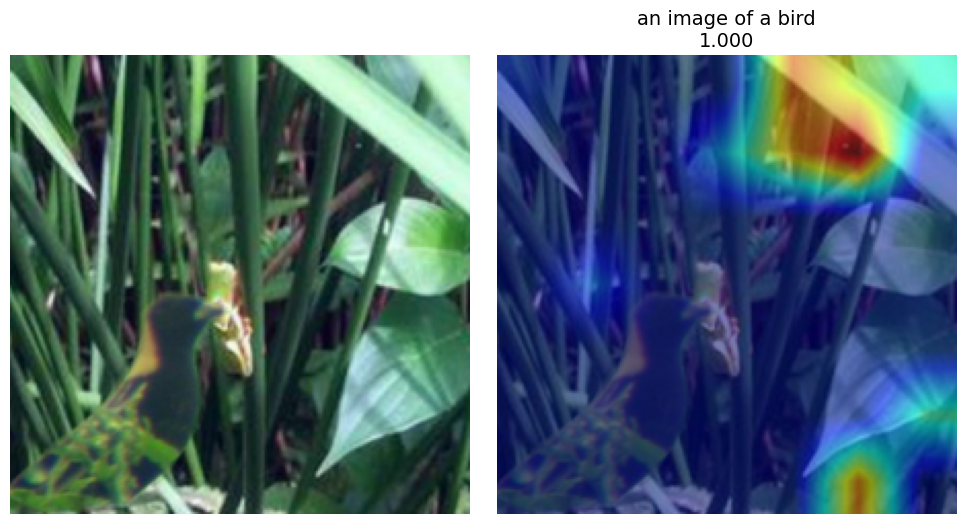

Processing image at path: /ProbVLM/Datasets/waterbird_1.0_forest2water2/013.Bobolink/Bobolink_0026_11057.jpg
torch.Size([1, 3, 224, 224]) torch.Size([1, 77])
torch.Size([1, 1024]) torch.Size([1, 1024])


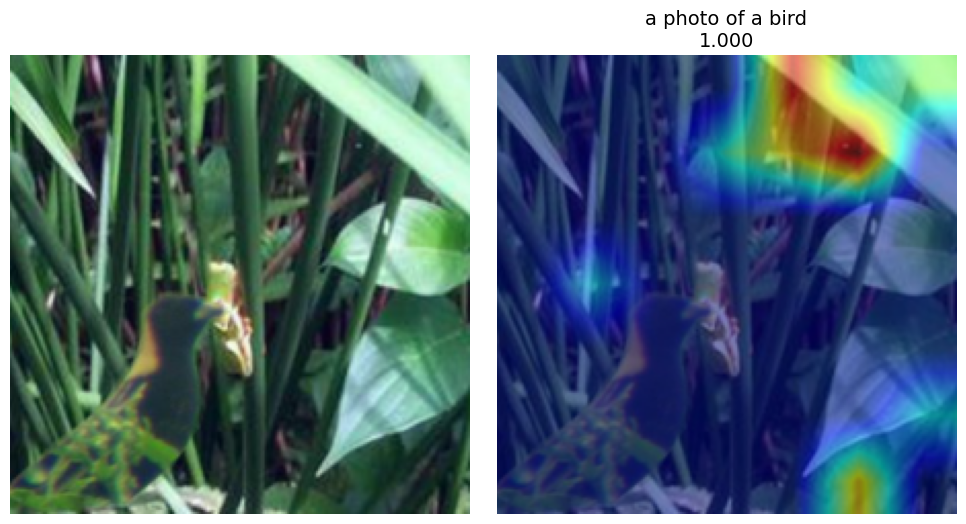

In [12]:
for i, batch in enumerate(cub_train_loader):
    
    xI, xT, paths = batch[0].to(device), batch[1].to(device), batch[4]
    t =0
    
    for img, txt, path in zip(xI, xT, paths):
        
        text_list = token_to_text(xT[t])
        t+=1
        img_name= path.split("/")[-1]

#         if img_name not in picture_names or text_list[0] not in ['a photo of a person', 'an image of a person']:
#             continue
            
        if "COCO_train2014_000000174229" not in path or text_list[0] not in ['a photo of a bird', 'an image of a bird']:
            continue


        img = img.unsqueeze(0)  # Add batch dimension for a single image
        txt = txt.unsqueeze(0)
        print(f"Processing image at path: {path}")
        print(img.shape, txt.shape)
        
                        # Ensure that the inputs are on the same device
        img = img.to(device)
        txt = txt.to(device)
        with torch.no_grad():
            
            xfI, xfT = CLIP_Net(img, txt)
            print(xfI.shape, xfT.shape)
            

        attentions, probs, unnorm_attentions, text_list = attention_model.forward(
            image_path=path,
            img_f=xfI.to(device),
            text_f=xfT.detach(),
            text_list= text_list,
            tok_t = txt,# Assuming `txt` is the textual input for the model
            tok_i = img,
            device=device
        )
            
        au.plot_attention_helper_p(
            image=img, 
            attentions=[attentions], 
            unnormalized_attentions=[unnorm_attentions], 
            probs=[probs], 
            text_list=text_list,
#             save_vis_path=False,  # Save path for each plot
            resize=False  # Set to True if resizing is needed
        )    